In [38]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io

from scipy import stats
from sklearn.linear_model import LinearRegression

# Import "local" packages
import hyspec_io, image_render, preprocess 

In [69]:
#%% Paths
raw_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Raw/OlbergholmenS-21/OlbergholmenS_Pika_L_21.bil.hdr'
radiance_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Radiance/OlbergholmenS_Pika_L_21-Radiance From Raw Data.bip.hdr'

# test_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Radiance/OlbergholmenS_Pika_L_16-Radiance From Raw Data.bip.hdr'
test_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Radiance/OlbergholmenS_Pika_L_17-Radiance From Raw Data.bip.hdr'

In [3]:
#%% Parameters
nir_band = (780,840)   # Indices for upper and lower wavelengths in NIR band

In [4]:
#%% Import data
(im_raw,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(raw_file)
(im_rad,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(radiance_file)

In [8]:
#%% Detect saturated pixels
sat_pix_mask = preprocess.detect_saturated(im_raw)
print('Number of saturated pixels: ' + str(np.count_nonzero(sat_pix_mask)))

Number of saturated pixels:66


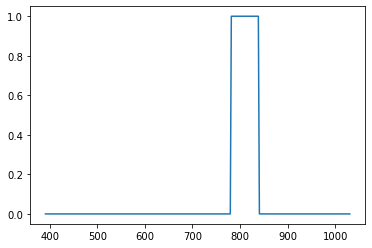

In [9]:
#%% Calc NIR indices and show as plot
nir_ind = (wl >= nir_band[0]) & (wl <= nir_band[1])
plt.plot(wl,nir_ind)

In [10]:
# Extract RGB and NIR images
im_rad_rgb = im_rad[:,:,rgb_ind]
im_rad_nir = np.mean(im_rad[:,:,nir_ind],axis=2)

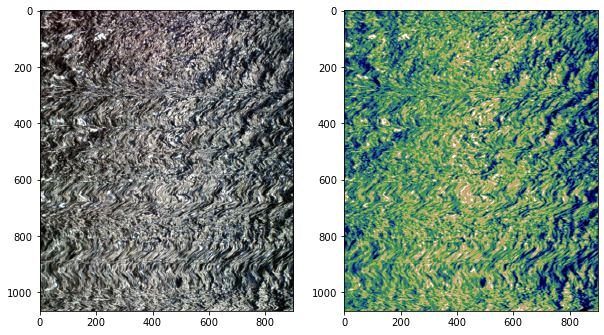

In [11]:
#%% Show RGB and NIR images 
fig,ax = plt.subplots(ncols=2,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im_rad_rgb))
ax[1].imshow(image_render.percentile_stretch(im_rad_nir,separate_bands = False),cmap='gist_earth')

In [17]:
#%% Extract all non-saturated NIR pixel values
nir = im_rad_nir[~sat_pix_mask]
print(nir.shape)

(959334,)


The NIR value will be used to predict the RGB values using linear regression. The LinearRegression fit() function expects its independent variables (X) to be a 2D matrix. In order to use the NIR value as X we have to rehape the 1D vector into a 2D matrix with a single column.

In [23]:
nir_rs = nir.reshape(-1,1)
nir_rs.shape

(959334, 1)

In [20]:
#%% Extract all non-saturated RGB values
rgb = im_rad_rgb[~sat_pix_mask]
print(rgb.shape)

(959334, 3)


In [24]:
#%% Fit a linear regression model using NIR as X and each R,B,G channel as y (multiple outputs is allowed)
reg = LinearRegression().fit(nir_rs, rgb)

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html for relevant example on linear regression.

In [30]:
reg.intercept_

array([ 40.69641, 183.09845, 232.78015], dtype=float32)

In [28]:
reg.coef_

array([[1.6215343],
       [1.7053926],
       [1.629254 ]], dtype=float32)

In [ ]:
The intercept_ values correspond to where the regression line intercepts the y axis. The coef_ values correspond to the slope of the regression line. 

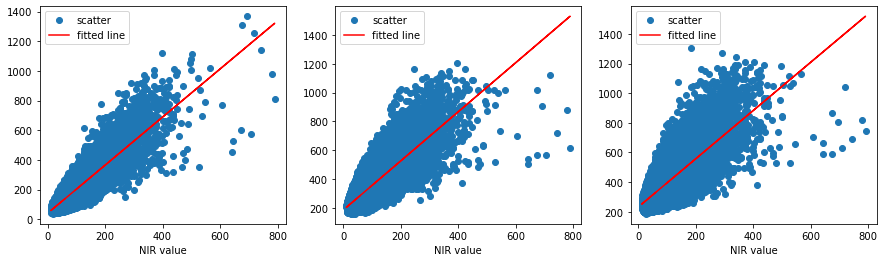

In [37]:
#%% Make scatter plots with regression lines overlayed
fig,ax = plt.subplots(ncols=3,figsize=(15,4))
for ii in range(3):
    ax[ii].plot(nir_rs, rgb[:,ii], 'o', label='scatter')
    ax[ii].plot(nir, reg.intercept_[ii] + reg.coef_[ii]*nir_rs, 'r', label='fitted line')
    ax[ii].legend()
    ax[ii].set_xlabel('NIR value')

The scatter plots above could be improved by estimating the "point density" and coloring the points accordingly. 
See e.g. https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

In [39]:
#%% "Predict" the RGB values based on NIR
im_rad_rgb_flat = np.reshape(im_rad_rgb,(im_rad_rgb.shape[0]*im_rad_rgb.shape[1],im_rad_rgb.shape[2]))
im_rad_rgb_flat.shape

(959400, 3)

In [40]:
im_rad_nir_flat = np.reshape(im_rad_nir,(im_rad_nir.size,1))
im_rad_nir_flat.shape

(959400, 1)

In [42]:
rgb_pred = reg.predict(im_rad_nir_flat)
rgb_pred.shape

(959400, 3)

In [46]:
im_rad_rgb_noglint = im_rad_rgb_flat - rgb_pred
im_rad_rgb_noglint = im_rad_rgb_noglint.reshape(im_rad_rgb.shape)
print(im_rad_rgb_noglint.shape)

(1066, 900, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


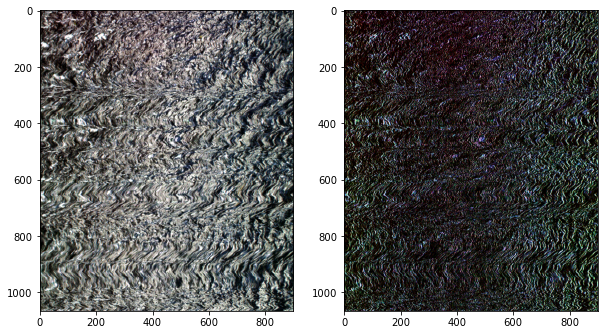

In [47]:
#%% Show original and glint corrected image
fig,ax = plt.subplots(ncols=2,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im_rad_rgb))
ax[1].imshow(image_render.percentile_stretch(im_rad_rgb_noglint))

In [49]:
print(np.mean(im_rad_rgb_flat,axis=0))

[193.84398 344.15988 386.66516]


In [51]:
print(np.mean(im_rad_rgb_noglint.reshape((-1,3)),axis=0))

[0.02527088 0.02016489 0.03363626]


In [52]:
from scipy import stats
stats.describe(im_rad_rgb_flat)

DescribeResult(nobs=959400, minmax=(array([ 36., 157., 185.], dtype=float32), array([1641., 1301., 1457.], dtype=float32)), mean=array([193.84398, 344.15988, 386.66516], dtype=float32), variance=array([5802.0947, 7354.5835, 7514.7534], dtype=float32), skewness=array([0.81033254, 0.67600113, 0.7705334 ], dtype=float32), kurtosis=array([3.0648847, 1.3560209, 2.044559 ], dtype=float32))

In [55]:
stats.describe(im_rad_rgb_noglint.reshape((-1,3)))

DescribeResult(nobs=959400, minmax=(array([-629.2019, -916.2322, -777.77  ], dtype=float32), array([686.77075, 713.0287 , 775.0835 ], dtype=float32)), mean=array([0.02527088, 0.02016489, 0.03363626], dtype=float32), variance=array([1150.2245, 2217.8154, 2817.3318], dtype=float32), skewness=array([0.38458693, 0.3319622 , 0.42984125], dtype=float32), kurtosis=array([3.9527779, 2.2111578, 2.0404224], dtype=float32))

In [70]:
#%% Apply to test file
(im_test,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(test_file)
test_rgb = im_test[:,:,rgb_ind]

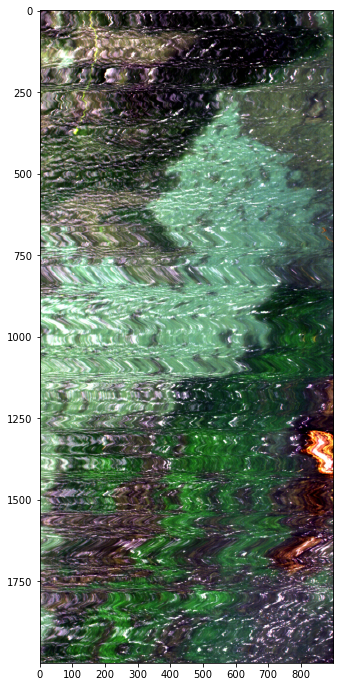

In [71]:
fig,ax = plt.subplots(ncols=1,figsize=(6,12))
ax.imshow(image_render.percentile_stretch(test_rgb))

In [72]:
test_nir = np.mean(im_test[:,:,nir_ind],axis=2)
test_nir = test_nir.reshape((-1,1))
test_nir.shape

(1800000, 1)

In [73]:
test_rgb_glint = reg.predict(test_nir)
test_rgb_glint.shape

(1800000, 3)

In [74]:
test_rgb_noglint = test_rgb - test_rgb_glint.reshape(test_rgb.shape)
test_rgb_noglint = test_rgb_noglint + 500     # Add small constant to avoid negative values...

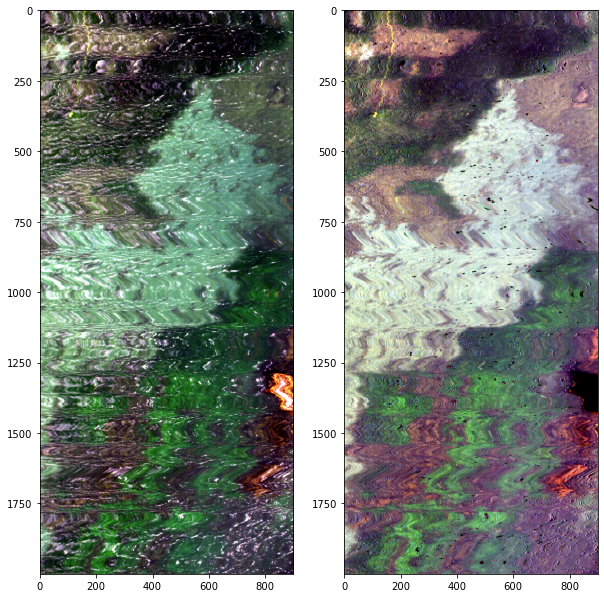

In [75]:
#%% Show original and glint corrected image
fig,ax = plt.subplots(ncols=2,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(test_rgb))
ax[1].imshow(image_render.percentile_stretch(test_rgb_noglint))